# Example: Single individual inference Schlögl model 

This notebook contains a tutorial on how to perform single-individual inference for the Schlögl-model using pseudo-marginal inference.

The Schlögl-data is simulated using the exact SSA-algorithm. 

To make the inference efficient the Langevin-approximation will be utlised for the inference (the number of molecules is high). Moreover, to account for the stochastic jumps a guided diffusion bridge filter is utlised for the pseudo-marginal inference, and particles are correlated to reduce the number of particles needed. 

In [2]:
# To get all the directories correct the directory must be the root directory of the PEPSDI-cloned file 
cd("/home/sebpe/Dropbox/PhD/Projects/PEPSDI")

# Required packages for formulating a model and do inference 
using Distributions # For placing priors 
using Random # For setting seed 
using LinearAlgebra # For matrix operations 
using Plots
tmp = push!(LOAD_PATH, pwd() * "/Code") # Push PEPSDI into load-path 
using PEPSDI # Load PEPSDI 

## Defining the Schlögl SDE-model 

A SDE-model (Langevin) is defined by the SDE; $dX_t = \alpha \mathrm{d}t + \beta \mathrm{d} W_t$, the observation model $y_{mod} = h(x, t)$ and lastly the error model, $y_{obs} = g(\epsilon)$, $\epsilon \sim \pi_{\epsilon}(\xi)$. To perform inference all these have to be defined. That is, a SDE-model consists of a:

* Function for the drift alpha 
* Function for the diffusion matrix beta 
* Function to calculate initial values 
    * Since the initial values can be unknown making the used provide a function for the initial values allows these to be inferred 
* Function for the observation y (h)
* Function for the probability of observing y (g)

For the Schlögl-model it is assumed that $y = \mathbf{P}^TX + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \xi^2)$. For a linear observation model like this the particles in the particle-filter can be propagated using guided proposals. Here we used the modified diffusion bridge propagators (note that this requires that $\mathbf{P}$ is provided when creaing the SDE-model).  



In [3]:
# The drift vector need to have arguments du, u, p, t (simular to julia differential equations)
# du : alpha-vector (not allocating new du is computationally efficient)
# u : current state-values 
# p : unknown model-quantites. p.c gives acces to individual parameters c, 
#     while p.kappa gives acces to cell-constants for multi-individual inference.  
# t : current time-value 
function schlogl_alpha(du, u, p, t)
    c = p.c
    c4 = 37.5
    h_vec1 = c[1] * u[1] * (u[1] - 1)
    h_vec2 = c[2] * u[1] * (u[1] - 1) * (u[1] - 2)
    h_vec3 = c[3]
    h_vec4 = c4 * u[1]

    @views du[1] = h_vec1 - h_vec2 + h_vec3 - h_vec4
end


# The diffusion matrix has the same arguments as the drift-vector. However, here du = beta (diffusion matrix)
function schlogl_beta(du, u, p, t)
    c = p.c
    c4 = 37.5
    h_vec1 = c[1] * u[1] * (u[1] - 1)
    h_vec2 = c[2] * u[1] * (u[1] - 1) * (u[1] - 2)
    h_vec3 = c[3]
    h_vec4 = c4 * u[1]
    
    @views du[1, 1] = h_vec1 + h_vec2 + h_vec3 + h_vec4
end


# The initial-value function needs to have the arguments u0, p. 
# u0 : vector with initial values (not allocating new du is efficient)
# p : as above (this allows initial values to be inferred)
function schlogl_u0!(u0, p) 
    u0[1] = 0.0
end


# The observation function y = g(X, p) must always have the arguments 
# y_mod, u, p, t
# y_mod : vector with model values at time t 
# u : state-values at time t
# p : as above (this allows y to depend on the parameters)
# t : current time-value 
function schlogl_h(y_mod, u, p, t)
    
    # g = X[1] -> y = X[1]
    y_mod[1] = u[1]
end


# The function for the probability to observe y_mod must always have the arguments 
# y_obs, y_mod, error_param, t, dim_obs. 
# y_obs : vector with observed values at time t (dimension = dim_obs)
# y_obs : vector with model values at time t (dimension = dim_obs)
# error_param : vector with error-parameters xi 
# t : current t-value 
# dim_obs, dimension of the observation vector y. 
function schlogl_g(y_obs, y_mod, error_param, t, dim_obs)
    
    # Since y_obs ~ N(y_mod, xi^2) the likelihood can be calculated 
    # via the normal distribution. Perform calculations on log-scale 
    # for stabillity. 
    prob::FLOAT = 0.0
    noise = error_param[1]
    error_dist = Normal(0.0, error_param[1])
    diff = y_obs[1] - y_mod[1]
    prob = logpdf(error_dist, diff)

    return exp(prob)
end


# P-matrix is the identity matrix here 
P_mat = [1]
sde_mod = init_sde_model(schlogl_alpha, 
                         schlogl_beta, 
                         schlogl_u0!, 
                         schlogl_h, 
                         schlogl_g, 
                         1,         # Model dimension dim(X)  
                         1,         # Dimension of observation model dim(Y)
                         P_mat) 


SdeModel{typeof(schlogl_alpha),typeof(schlogl_beta),typeof(schlogl_u0!),typeof(schlogl_h),typeof(schlogl_g),Int64,StaticArrays.SArray{Tuple{1,1},Float64,2,1},StaticArrays.SArray{Tuple{1,1},Float64,2,1}}(schlogl_alpha, schlogl_beta, schlogl_u0!, 1, schlogl_h, schlogl_g, 1, [1.0], [1.0])

## Defining inference options 

Before performing the inference there are multiple options that must be set: 

* Priors for the individual parameters $\mathbf{c}$ and measurment error parameters $\xi$. 
    * Almost any distribution in the Julia distributions pacakge can be used. 
* If the parameters are inferred on normal, or, log-scale 
    * Performing inference on the log-scale means to infer $log(c)$ instead of $\mathbf{c}$. This can help explore the posterior more efficiently  (which is why we do it below) inference perspective. 
* If a parameters are constrained to positive values
* Which particle filter to use for pseudo-marginal inference 
    * For SDE-model step-length when solving the model most be provided 
    * For SDE-models the particles can also be correlated 
* Which adaptive mcmc-proposals scheme to propose new parameters with  
    * As noted in the paper, we found the RAM-sampler to be efficient. Thus, we use it below.  
* Location of data-file with observed data and where to save the results 
    

In [4]:
# As we infer parameters on the log-scale, log(c), the priors are placed for 
# log(c), note the priors are wide on c, and that priors are provided as an array.  
prior_ind_param = [Normal(-1.0, 10.0), 
                   Normal(-3.0, 10.0), 
                   Normal(7.0, 10.0)]

# Strict prior on xi
prior_error_param = [Normal(2.0, 0.5)]

# Set options for individual parameters during inference 
param_info = init_param(prior_ind_param, 
                        prior_error_param, 
                        ind_param_pos=false,  # c are not forced to be positive 
                        ind_param_log=true,   # c inferred on log-scale 
                        error_param_pos=true) # ξ forced to be positive 

# Choosing a particle filter 
dt = 2e-2 # Step-length when simulating the model 
rho = 0.99 # Correlation level between particles 
# Use the modified diffusion bridge filter 
filter_opt = init_filter(ModDiffusion(), dt, rho=0.99)

# Choose adaptive mcmc-scheme when proposing parameters 
cov_mat_use = diagm([0.1, 0.1, 0.1, 0.1]) # Starting covariance matrix for the RAM-sampler 
mcmc_sampler = init_mcmc(RamSampler(), param_info, cov_mat=cov_mat_use)

# Set up struct that stores all file-locations 
path_data = pwd() * "/Intermediate/Simulated_data/SSA/Schlogl/Schlogl.csv" # Where observed data is saved
file_loc = init_file_loc(path_data, "Example/Schlogl_single_ind/")



FileLocations{Array{String,1},Array{Float64,1},Array{Int64,1}}("/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Simulated_data/SSA/Schlogl/Schlogl.csv", "Example/Schlogl_single_ind/", "/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Single_individual/Example/Schlogl_single_ind/", [""], Float64[], [1])

## Perform pilot run 

To perform efficient pseduo-marginal inference we want to take as many samples as possible, without risking that the chain gets stuck. As noted in the paper this can be achieved if we tune the number of particles. 

A often using tuning approach is to first run a pilot-run to end up in a central posterior location. From this central location the particles can then be tuned according to tuning criteria (see paper supplementary 5.2). The tuning criteria aims to acheive as few particles as possible. 

For the pilot run it is important to use many particles, else the mcmc-chain can get stuck. This is because the variabillity of the likelihood is larger far away from a posterior mode.  

PEPSDI will write the number of particles calculated by the tuning scheme to disk. Furthermore, to avoid having to re-run a pilot run PEPSDI will also write the options for a particular pilot-run to disk (number of samples, corellation-level, starting values)

The results from the pilot run is stored in *Intermediate/Single_individual/Name_in_file_loc*. 

In [5]:
# Set up options for pilot-run 
pilot_run_info = init_pilot_run([prior_ind_param, prior_error_param], # Priors [prior_c, prior_xi]
                                 init_ind_param=log.([1.2e-1, 2.1e-4, 2.7e3]), # Initial values on c 
                                 n_particles_pilot=1000, # Number of particles for pilot-run 
                                 n_samples_pilot=5000, # Number of samples for pilot-run 
                                 n_times_run_filter=50, # Number of times to run filter when tuning (50 often works)
                                 rho_list=[0.99]) # Correlation level to use in particle filter for pilot run and tuning 

# Run pilot run single individual inference 
tune_particles_single_individual(pilot_run_info, 
                                 mcmc_sampler, 
                                 param_info, 
                                 filter_opt, 
                                 sde_mod, 
                                 deepcopy(file_loc))



Testing particles for experiment = 1 using a correlation level of = 0.990
For start-guess 1, particles_use = 10 


## Perform main run 

After the pilot-run the main inference run can be performed. Since the pilot-run, hopefully, arrived at a mode a good starting location is the end-location of the pilot run. 

For single-individual inference the parameter-info struct, the adaptive mcmc-sampler, and the filter can be launched based on pilot data. Currently, as below, this has to be written explicetely (for multi-individual inference this is more sophisticated). To launch the inference based on the pilot-run, each pilo is equipped with an experimental id (exp_id/exp_tag) that can be used to load the particles from a particular run (see below). 

In [6]:
n_samples = 60000
        
# Obtain starting values from pilot run 
param_info_new = change_start_val_to_pilots(param_info, file_loc, filter_opt, sampler_name = "Ram_sampler", exp_id=1)

# Use the tuned RAM-sampler from pilot run 
mcmc_sampler = init_mcmc_pilot(RamSampler(), file_loc, filter_opt.rho, exp_tag = 1)
    
# Use the number of particles from the tuning criteria 
filter_opt = init_filter_pilot(filter_opt, file_loc, rho, "Ram_sampler", exp_tag = 1)

# Run the main inference run 
samples, log_lik_val, sampler = run_mcmc(n_samples, mcmc_sampler, param_info_new, filter_opt, sde_mod, file_loc)                      

println("Done")

Running single individual inference with: 10 particles and correlation level 0.990
Log_lik_start = -543.142


Running sampler...100%|█████████████████████████████████| Time: 0:04:32


Done


## Plot the inference results

The red-line corresponds to the true-value, highlighting that PEPSDI accurately infers the true parameters values. 

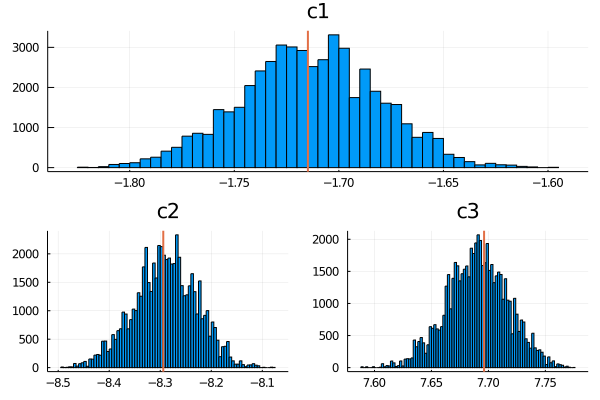

In [7]:
# Plot the inference results  
p1 = histogram(samples[1, 10000:end], title = "c1", label=false)
vline!([log(1.8e-1)], lw = 2, label=false)

p2 = histogram(samples[2, :], title = "c2", label=false)
vline!([log(2.5e-4)], lw = 2, label=false)

p3 = histogram(samples[3, :], title = "c3", label=false)
vline!([log(2.2e3)], lw = 2, label=false)

l = @layout [a ; b c]
plot(p1, p2, p3, layout = l)